In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,sys, gc
import keras

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC,generate_representation
from evaluation import calculate_metrics

folder = "../../KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"

Using TensorFlow backend.


### Load Metadata and pre-process

In [2]:
def impute_on_pandas(df):
    return df.fillna(df.median(),inplace=False)

df_meta = pd.read_csv(folder+"/kepler_dataset.csv")
all_labels = df_meta["NExScI Disposition"]
mask_conf = (all_labels=="CONFIRMED").values
mask_fp = (all_labels=="FALSE POSITIVE").values
mask_cand = (all_labels=="CANDIDATE").values

metadata_used = ["Period", "Duration", "Time of Transit Epoch",
                 "Inclination", "Semi-major Axis", "r/R",
                 "Teq", "Transit Number", "Limb Darkening Coeff1", "Limb Darkening Coeff2"]
df_meta_obj = df_meta[metadata_used]
mask_nan = pd.isna(df_meta_obj)

df_meta_obj = impute_on_pandas(df_meta_obj)

df_meta_obj.head()

Period  Duration  Time of Transit Epoch  Inclination  Semi-major Axis  \
0    8.884923   2.07004             169.991686        89.89            0.079   
1    5.092465   3.65900             357.535940        89.14            0.052   
2  275.073650   3.37000             315.248600        89.93            0.789   
3    8.460439   4.73492             133.774490        85.68            0.075   
4   21.761298   1.24300             166.540438        89.95            0.140   

     r/R    Teq  Transit Number  Limb Darkening Coeff1  Limb Darkening Coeff2  
0  0.114  770.0             153                  0.497                  0.204  
1  0.014  844.0             225                  0.551                  0.165  
2  0.014  303.0               4                  0.437                  0.243  
3  0.478  804.0             164                  0.299                  0.306  
4  0.032  486.0              62                  0.627                  0.108

In [3]:
df_sets = pd.read_csv(folder+"/koi_sets_unb.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values

mask_train_conf = mask_conf & mask_train
mask_test_conf = mask_conf & mask_test

In [4]:
Y_train = df_meta_obj.values[mask_train_conf]
Y_test = df_meta_obj.values[mask_test_conf]
Y_train.shape

(1776, 10)

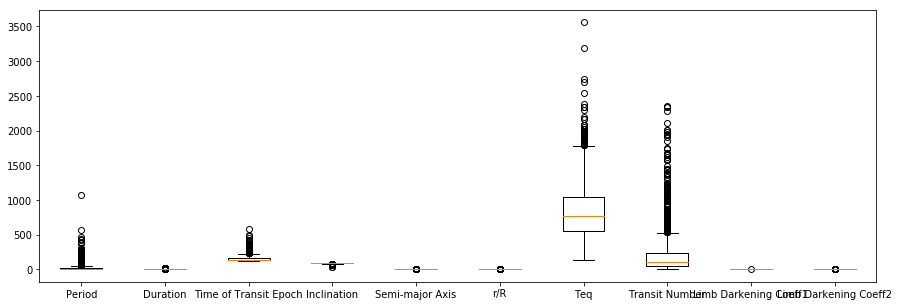

Period     Duration  Time of Transit Epoch  Inclination  \
count  1776.000000  1776.000000            1776.000000  1776.000000   
mean     26.770958     4.278104             156.863733    87.975490   
std      53.253481     2.712936              42.055219     3.507531   
min       0.341842     0.427900             120.565925    40.980000   
25%       5.012505     2.524075             134.249478    87.580000   
50%      11.326234     3.552450             140.587130    89.100000   
75%      25.372859     5.252250             170.977483    89.810000   
max    1071.232624    24.420000             589.719750    90.000000   

       Semi-major Axis          r/R          Teq  Transit Number  \
count      1776.000000  1776.000000  1776.000000     1776.000000   
mean          0.141385     0.025715   840.867680      207.111486   
std           0.151109     0.022297   396.090465      296.638191   
min           0.006000     0.005000   129.000000        3.000000   
25%           0.055000     0.014000   553.000000       47.000000   
50%           0.095000     0.021000   771.000000      107.000000   
75%           0.168000     0.029000  1046.000000      242.000000   
max           1.860000     0.415000  3559.000000     2354.000000   

       Limb Darkening Coeff1  Limb Darkening Coeff2  
count            1776.000000            1776.000000  
mean                0.436031               0.242360  
std                 0.099668               0.067242  
min                 0.210000               0.034000  
25%                 0.359000               0.204000  
50%                 0.419000               0.260000  
75%                 0.497000               0.289000  
max                 0.731000               0.442000

In [5]:
### boxplot de las variables..
plt.figure(figsize=(15,5))
plt.boxplot(Y_train)
plt.xticks(np.arange(len(metadata_used))+1,metadata_used)
plt.show()
aux_df = pd.DataFrame(Y_train)
aux_df.columns = metadata_used
aux_df.describe()

In [5]:
#pre-process: scale metadata
from sklearn.preprocessing import StandardScaler, RobustScaler
#scaler_meta = RobustScaler()
scaler_meta = StandardScaler()

Ystd_train = scaler_meta.fit_transform(Y_train)
Ystd_test = scaler_meta.transform(Y_test)

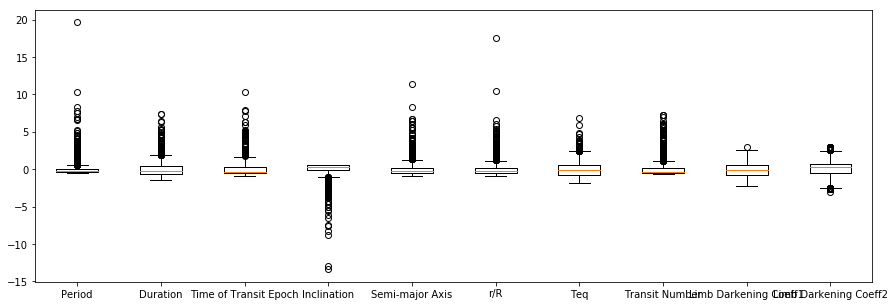

Period      Duration  Time of Transit Epoch   Inclination  \
count  1.776000e+03  1.776000e+03           1.776000e+03  1.776000e+03   
mean  -7.285839e-17  6.227188e-16           6.990686e-15 -7.418934e-14   
std    1.000282e+00  1.000282e+00           1.000282e+00  1.000282e+00   
min   -4.964288e-01 -1.419601e+00          -8.633419e-01 -1.340223e+01   
25%   -4.086978e-01 -6.467246e-01          -5.378791e-01 -1.127862e-01   
50%   -2.901045e-01 -2.675544e-01          -3.871383e-01  3.206891e-01   
75%   -2.626105e-02  3.591757e-01           3.356950e-01  5.231677e-01   
max    1.961855e+01  7.426481e+00           1.029546e+01  5.773521e-01   

       Semi-major Axis           r/R           Teq  Transit Number  \
count     1.776000e+03  1.776000e+03  1.776000e+03    1.776000e+03   
mean     -7.514009e-17 -3.722201e-15 -5.188542e-18   -4.071130e-17   
std       1.000282e+00  1.000282e+00  1.000282e+00    1.000282e+00   
min      -8.961943e-01 -9.292957e-01 -1.797741e+00   -6.882761e-01   
25%      -5.718343e-01 -5.255484e-01 -7.269773e-01   -5.399055e-01   
50%      -3.070507e-01 -2.115228e-01 -1.764429e-01   -3.375819e-01   
75%       1.761795e-01  1.473637e-01  5.180385e-01    1.176461e-01   
max       1.137653e+01  1.746364e+01  6.864336e+00    7.239436e+00   

       Limb Darkening Coeff1  Limb Darkening Coeff2  
count           1.776000e+03           1.776000e+03  
mean           -1.323991e-14           2.691253e-14  
std             1.000282e+00           1.000282e+00  
min            -2.268470e+00          -3.099549e+00  
25%            -7.730908e-01          -5.706383e-01  
50%            -1.709246e-01           2.624147e-01  
75%             6.118915e-01           6.938172e-01  
max             2.960340e+00           2.969837e+00

In [6]:
### boxplot de las variables..
plt.figure(figsize=(15,5))
plt.boxplot(Ystd_train)
plt.xticks(np.arange(len(metadata_used))+1,metadata_used)
plt.show()
aux_df = pd.DataFrame(Ystd_train)
aux_df.columns = metadata_used
aux_df.describe()

In [6]:
#probar agregar errores
metadata_errors = ["Period err1", "Period err2", "Duration err1", "Duration err2", "Time err1", "Time err2",
                  "Inclination err1", "Inclination err2", "Semi-major Axus err1", "Semi-major Axis err2",
                  "r/R err1", "r/R err2", "Teq err1", "Teq err2", "Transit Number"]
aux = df_meta[metadata_errors].abs()

df_meta_err = pd.DataFrame()
df_meta_err["Period err"] = (aux["Period err1"]+aux["Period err2"])/2
df_meta_err["Duration err"] = (aux["Duration err1"]+aux["Duration err2"])/2
df_meta_err["Time err"] = (aux["Time err1"]+aux["Time err2"])/2
df_meta_err["Inclination err"] = (aux["Inclination err1"]+aux["Inclination err2"])/2
df_meta_err["Semi-major Axis err"] = (aux["Semi-major Axus err1"]+aux["Semi-major Axis err2"])/2
df_meta_err["r/R err"] = (aux["r/R err1"]+aux["r/R err2"])/2
df_meta_err["Teq err"] = (aux["Teq err1"]+aux["Teq err2"])/2
df_meta_err["Number err"] = np.nan
df_meta_err["Coeff1 err"] = np.nan
df_meta_err["Coeff2 err"] = np.nan

mask_nan_err = pd.isna(df_meta_err)

df_meta_err.head()

Period err  Duration err  Time err  Inclination err  Semi-major Axis err  \
0  1.636000e-06         0.007  0.000144              NaN                  NaN   
1  4.390000e-05         0.199  0.005000              NaN                  NaN   
2  3.900000e-02         5.500  0.094000              NaN                  NaN   
3  6.290000e-07         0.003  0.000063              NaN                  NaN   
4  1.727000e-05         0.026  0.000641              NaN                  NaN   

    r/R err  Teq err  Number err  Coeff1 err  Coeff2 err  
0  0.000331      NaN         NaN         NaN         NaN  
1  0.000661      NaN         NaN         NaN         NaN  
2  0.001246      NaN         NaN         NaN         NaN  
3  0.010500      NaN         NaN         NaN         NaN  
4  0.000770      NaN         NaN         NaN         NaN

In [7]:
Y_train_err = df_meta_err.values[mask_train_conf]
#Y_test_err = df_meta_err.values[mask_test_conf]
Y_train_err.shape

(1776, 10)

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


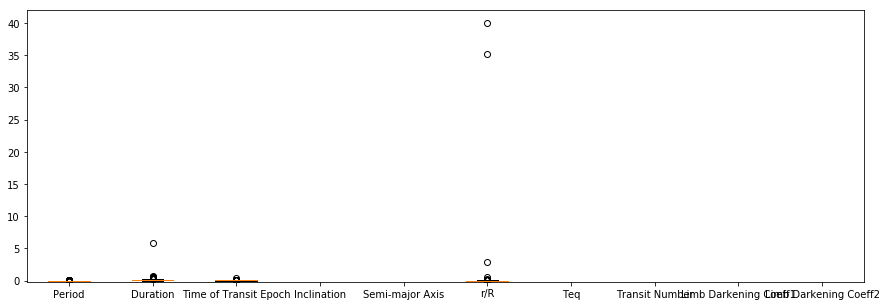

Period    Duration  Time of Transit Epoch  Inclination  \
count  5.050000e+02  505.000000             505.000000          0.0   
mean   2.723024e-04    0.129247               0.004544          NaN   
std    2.307667e-03    0.276396               0.016095          NaN   
min    7.100000e-08    0.000730               0.000025          NaN   
25%    1.266000e-05    0.054000               0.001000          NaN   
50%    3.311000e-05    0.088000               0.003000          NaN   
75%    1.205000e-04    0.148000               0.005000          NaN   
max    5.100000e-02    5.900000               0.345000          NaN   

       Semi-major Axis         r/R  Teq  Transit Number  \
count              0.0  505.000000  0.0             0.0   
mean               NaN    0.157463  NaN             NaN   
std                NaN    2.372793  NaN             NaN   
min                NaN    0.000066  NaN             NaN   
25%                NaN    0.000468  NaN             NaN   
50%                NaN    0.000831  NaN             NaN   
75%                NaN    0.002000  NaN             NaN   
max                NaN   40.034500  NaN             NaN   

       Limb Darkening Coeff1  Limb Darkening Coeff2  
count                    0.0                    0.0  
mean                     NaN                    NaN  
std                      NaN                    NaN  
min                      NaN                    NaN  
25%                      NaN                    NaN  
50%                      NaN                    NaN  
75%                      NaN                    NaN  
max                      NaN                    NaN

In [43]:
### boxplot de las variables..
plt.figure(figsize=(15,5))
plt.boxplot(Y_test_err)
plt.xticks(np.arange(len(metadata_used))+1,metadata_used)
plt.ylim(-0.2)
plt.show()
aux_df = pd.DataFrame(Y_test_err)
aux_df.columns = metadata_used
aux_df.describe()

In [8]:
Ystd_train_err = Y_train_err/ scaler_meta.scale_
#Ystd_test_err = Y_test_err/ scaler_meta.scale_

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


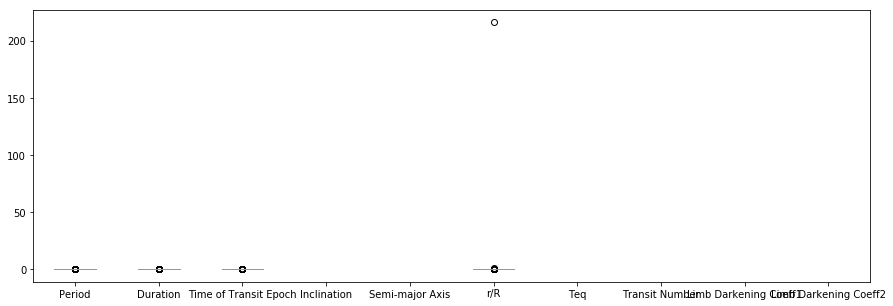

Period      Duration  Time of Transit Epoch  Inclination  \
count  1.776000e+03  1.776000e+03           1.776000e+03          0.0   
mean   7.297788e-14  6.433805e-06           1.560230e-10          NaN   
std    2.735139e-13  6.182039e-06           2.623024e-10          NaN   
min    1.014196e-17  4.219924e-08           3.351447e-13          NaN   
25%    4.099983e-15  2.705080e-06           3.852238e-11          NaN   
50%    1.438656e-14  4.760940e-06           1.155671e-10          NaN   
75%    4.654974e-14  8.331645e-06           1.926119e-10          NaN   
max    5.258796e-12  6.492191e-05           4.853820e-09          NaN   

       Semi-major Axis          r/R  Teq  Transit Number  \
count              0.0  1776.000000  0.0             0.0   
mean               NaN     0.131200  NaN             NaN   
std                NaN     5.128310  NaN             NaN   
min                NaN     0.000269  NaN             NaN   
25%                NaN     0.002940  NaN             NaN   
50%                NaN     0.004894  NaN             NaN   
75%                NaN     0.011959  NaN             NaN   
max                NaN   216.124642  NaN             NaN   

       Limb Darkening Coeff1  Limb Darkening Coeff2  
count                    0.0                    0.0  
mean                     NaN                    NaN  
std                      NaN                    NaN  
min                      NaN                    NaN  
25%                      NaN                    NaN  
50%                      NaN                    NaN  
75%                      NaN                    NaN  
max                      NaN                    NaN

In [86]:
### boxplot de las variables..
plt.figure(figsize=(15,5))
plt.boxplot(Ystd_train_err)
plt.xticks(np.arange(len(metadata_used))+1,metadata_used)
#plt.ylim(-0.2,1)
plt.show()
aux_df = pd.DataFrame(Ystd_train_err)
aux_df.columns = metadata_used
aux_df.describe()

In [9]:
Ystd_train_err[mask_nan_err[mask_train_conf]] = np.nanmin(Ystd_train_err)


In [11]:
Ystd_train_err[mask_nan_err[mask_train_conf]] = 1
#Ystd_test_err[mask_nan_err[mask_test_conf]] = 1

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler_meta_err = MinMaxScaler(feature_range=(1, 100)) #o un shift de 1...

Ystd_train_err = scaler_meta_err.fit_transform(Ystd_train_err)
#Ystd_test_err = scaler_meta_err.transform(Ystd_test_err)

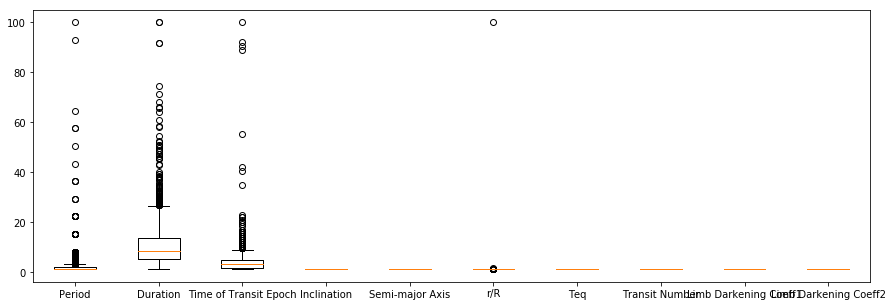

Period     Duration  Time of Transit Epoch  Inclination  \
count  1776.000000  1776.000000            1776.000000       1776.0   
mean      2.373664    10.752956               4.175677          1.0   
std       5.149073     9.433177               5.350369          0.0   
min       1.000000     1.000000               1.000000          1.0   
25%       1.076994     5.063291               1.778932          1.0   
50%       1.270645     8.200330               3.350469          1.0   
75%       1.876138    13.648872               4.922007          1.0   
max     100.000000   100.000000             100.000000          1.0   

       Semi-major Axis          r/R     Teq  Transit Number  \
count           1776.0  1776.000000  1776.0          1776.0   
mean               1.0     1.059976     1.0             1.0   
std                0.0     2.349123     0.0             0.0   
min                1.0     1.000000     1.0             1.0   
25%                1.0     1.001224     1.0             1.0   
50%                1.0     1.002119     1.0             1.0   
75%                1.0     1.005355     1.0             1.0   
max                1.0   100.000000     1.0             1.0   

       Limb Darkening Coeff1  Limb Darkening Coeff2  
count                 1776.0                 1776.0  
mean                     1.0                    1.0  
std                      0.0                    0.0  
min                      1.0                    1.0  
25%                      1.0                    1.0  
50%                      1.0                    1.0  
75%                      1.0                    1.0  
max                      1.0                    1.0

In [12]:
### boxplot de las variables..
plt.figure(figsize=(15,5))
plt.boxplot(Ystd_train_err)
plt.xticks(np.arange(len(metadata_used))+1,metadata_used)
plt.show()
aux_df = pd.DataFrame(Ystd_train_err)
aux_df.columns = metadata_used
aux_df.describe()

### Read light curves processed (detrended)

In [13]:
time_kepler = np.load(folder_lc+"npy/KOI_LC_time.npy")
#lc_kepler = np.load(folder_lc+"npy/KOI_LC_init.npy" )
process_lc = np.load(folder_lc+'/cleaned/LC_kepler_processed.npy')
N, T = time_kepler.shape
print((N,T))

(8054, 71427)


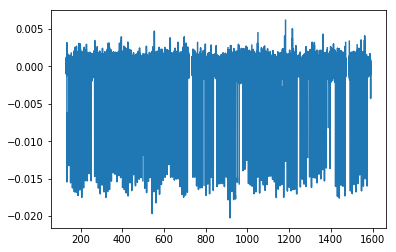

In [9]:
plt.plot(time_kepler[0],process_lc[0])
plt.show()

In [14]:
### mascara para solo confirmados???
time_kepler = time_kepler[mask_conf]
process_lc = process_lc[mask_conf]
N, T = time_kepler.shape
print((N,T))

(2281, 71427)


## Generate representation
> Continous values (with zeros)  
>> **Selected:** Coupled values (adding time) + delta time

In [15]:
for i in range(N):
    if i%1000 == 0:
        print("Va en el ",i)
    time_kepler[i], process_lc[i] = generate_representation(time_kepler[i], process_lc[i])

Va en el  0
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423941 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampli

New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old le

In [16]:
#borrar nans... arreglo variable
coupled_lc = []
coupled_time = []
delta_time = []
for i in range(N):
    mask_nan_aux = np.isnan(process_lc[i])
    coupled_lc.append(process_lc[i][~mask_nan_aux])
    
    time = time_kepler[i][~mask_nan_aux]
    # calculate delta time --> this could be done after padding is done..
    delta_time.append(np.hstack([[0],np.diff(time)]))
    coupled_time.append(time)
    
coupled_lc = np.asarray(coupled_lc)
coupled_time = np.asarray(coupled_time)
delta_time = np.asarray(delta_time)
coupled_time

array([array([ 131.5127147 ,  131.53314799,  131.55358129, ..., 1590.94020852,
       1590.96064181, 1590.98107511]),
       array([ 131.5126641 ,  131.53309739,  131.55353069, ..., 1590.94017122,
       1590.96060451, 1590.98103781]),
       array([ 131.5127088 ,  131.53314209,  131.55357539, ..., 1590.94023102,
       1590.96066431, 1590.98109761]),
       ...,
       array([ 131.5119906,  131.5324239,  131.5528572, ..., 1590.9400861,
       1590.9605194, 1590.9809527]),
       array([ 131.5119561,  131.5323894,  131.5528227, ..., 1590.9400454,
       1590.9604787, 1590.980912 ]),
       array([ 131.5119643,  131.5323976,  131.5528309, ..., 1590.9400596,
       1590.9604929, 1590.9809262])], dtype=object)

### Process --scale and center
> center?  
> With what value scale? (min, iqr, std)  
> Multiplicar por -1 por los max pooling?
>> **Selected:** normalizar (unit variance) --already median centered 

In [17]:
#pre-process seleccionado

coupled_lc_scaled = []
for i in range(coupled_lc.shape[0]):
    std_i = coupled_lc[i].std(keepdims=True)
    coupled_lc_scaled.append( coupled_lc[i]/std_i )
coupled_lc_scaled = np.asarray(coupled_lc_scaled)
coupled_lc_scaled.shape

(2281,)

In [18]:
#flip/mirror cada curva de luz.. (así se duplican los datos..) time: tambn y shift del 0 que sobra..

flip_coupled_lc_scaled = []
flip_delta_time = []
for i in range(coupled_lc.shape[0]):    
    flip_coupled_lc_scaled.append( coupled_lc_scaled[i][::-1] )
    flip_delta_time.append(  np.hstack([[0], delta_time[i][1:][::-1]]) )
    
flip_coupled_lc_scaled = np.asarray(flip_coupled_lc_scaled)
flip_delta_time = np.asarray(flip_delta_time)


delta_time = np.concatenate([flip_delta_time,delta_time])
coupled_lc_scaled = np.concatenate([flip_coupled_lc_scaled,coupled_lc_scaled])

del flip_delta_time, flip_coupled_lc_scaled
gc.collect()
coupled_lc_scaled.shape

(4562,)

### Padding for Keras

In [19]:
lens_lc = list(map(len,coupled_time))
max_len = np.max(lens_lc)

## do padding with keras..
X_time = keras.preprocessing.sequence.pad_sequences(delta_time,maxlen=max_len, value=0,dtype='float32',padding='post')
X_lc_scaled = keras.preprocessing.sequence.pad_sequences(coupled_lc_scaled,maxlen=max_len, value=0,dtype='float32',padding='post')

print("Shape with padding: ", X_lc_scaled.shape)
X_lc_scaled

Shape with padding:  (4562, 64461)


array([[-0.08730856, -3.0120108 ,  0.06760287, ...,  0.        ,
         0.        ,  0.        ],
       [-0.27543724, -9.160291  ,  0.7185589 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.15168639,  1.1390879 , -0.31746146, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.40176523,  0.55774933,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.96442634,  1.0596648 ,  0.4071325 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0009062 ,  0.29136676, -1.8706189 , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [20]:
#need data with extra dim
X_lc_scaled = np.expand_dims(np.squeeze(X_lc_scaled),axis=-1)
X_time = np.expand_dims(np.squeeze(X_time),axis=-1)

T = X_lc_scaled.shape[1]
channels = 2
X_lc_scaled.shape

(4562, 64461, 1)

### Load Encoder

In [21]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, Dense, Flatten, MaxPool1D, Reshape, UpSampling1D, Lambda, AveragePooling1D
from keras.layers import GlobalAveragePooling1D,GlobalMaxPool1D, TimeDistributed, GRU,LSTM, RepeatVector
from keras.layers import BatchNormalization, Dropout, ZeroPadding1D, ZeroPadding2D, Cropping1D, Cropping2D, Conv2D, Conv2DTranspose, MaxPool2D,UpSampling2D

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

D_dim = 8

In [22]:
### load encoder..
#encoder_model = keras.models.load_model("En_op1.h5")
encoder_model = keras.models.load_model("En_op4.h5")
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64482, 2)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64482, 8)          88        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64482, 8)          328       
_________________________________________________________________
average_pooling1d_1 (Average (None, 32241, 8)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32241, 16)         656       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 32241, 16)         1296      
_________________________________________________________________
average_pooling1d_2 (Average (None, 16120, 16)         0         
__________

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
#encode light curves...
X_enc_lc  = encoder_model.predict(np.concatenate([X_lc_scaled,X_time],axis=2))
X_enc_lc.shape

ValueError: Error when checking : expected input_1 to have shape (64482, 2) but got array with shape (64461, 2)

In [23]:
max_len = 64482

## do padding with keras..
X_time = keras.preprocessing.sequence.pad_sequences(delta_time,maxlen=max_len, value=0,dtype='float32',padding='post')
X_lc_scaled = keras.preprocessing.sequence.pad_sequences(coupled_lc_scaled,maxlen=max_len, value=0,dtype='float32',padding='post')
print("Shape with padding: ", X_lc_scaled.shape)

#need data with extra dim
T = X_lc_scaled.shape[1]
channels = 2
X_lc_scaled = np.expand_dims(np.squeeze(X_lc_scaled),axis=-1)
X_time = np.expand_dims(np.squeeze(X_time),axis=-1)
X_lc_scaled.shape

Shape with padding:  (4562, 64482)


(4562, 64482, 1)

In [24]:
#encode light curves...
X_lc_scaled_real = X_lc_scaled[:N] 
X_lc_scaled_aug  = X_lc_scaled[N:] 
X_time_real = X_time[:N] 
X_time_aug  = X_time[N:] 

X_enc_lc_real  = encoder_model.predict(np.concatenate([X_lc_scaled_real,X_time_real],axis=2))
X_enc_lc_aug  = encoder_model.predict(np.concatenate([X_lc_scaled_aug,X_time_aug],axis=2))
X_enc_lc_real.shape

(2281, 2015, 128)

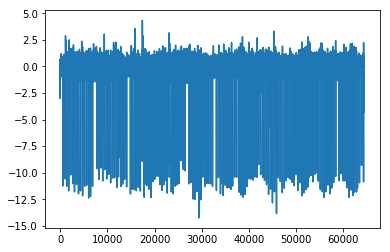

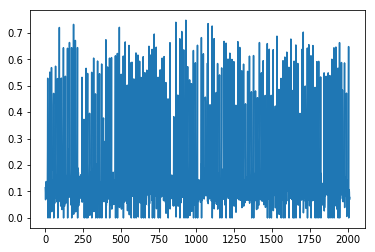

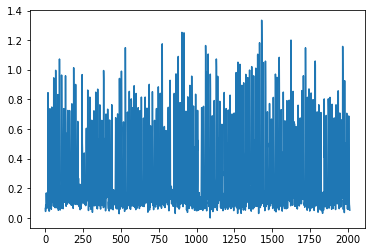

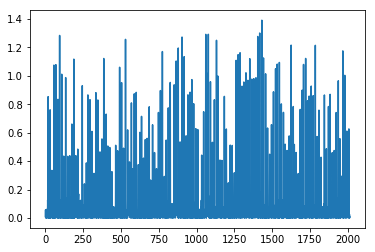

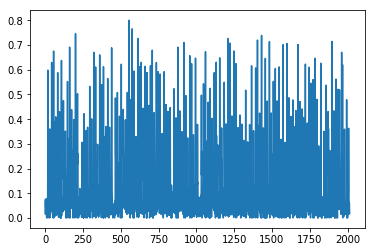

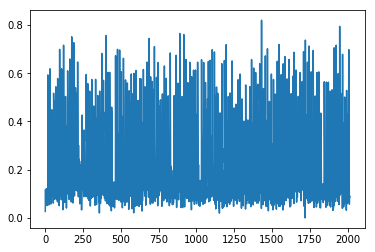

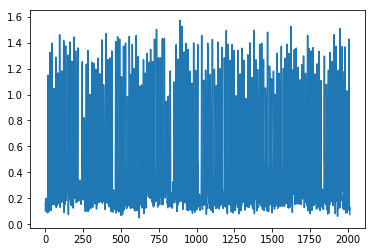

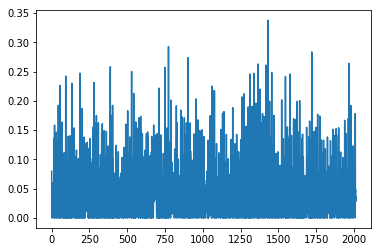

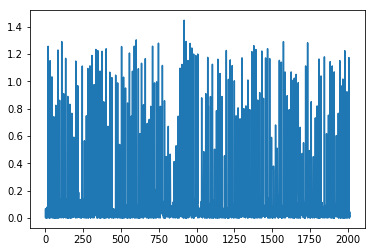

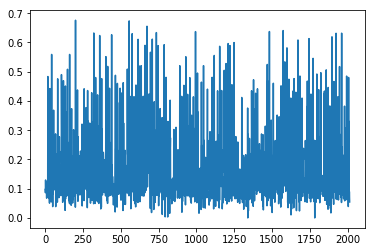

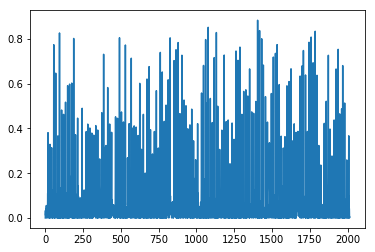

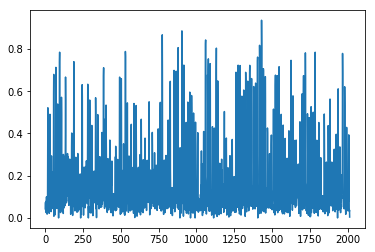

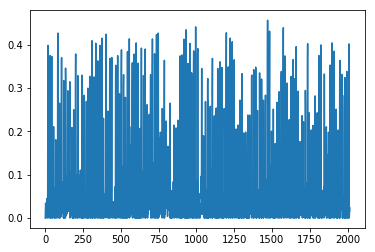

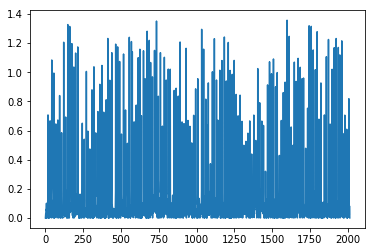

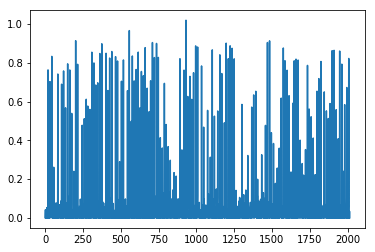

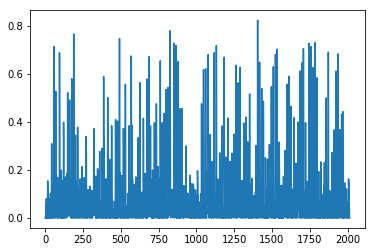

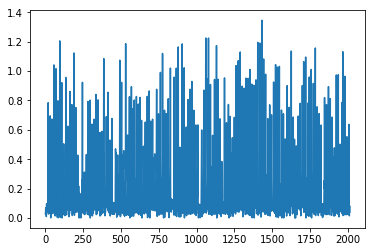

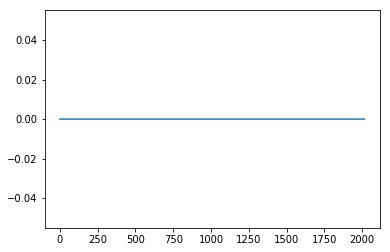

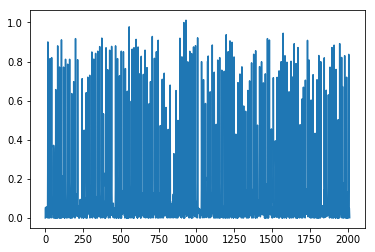

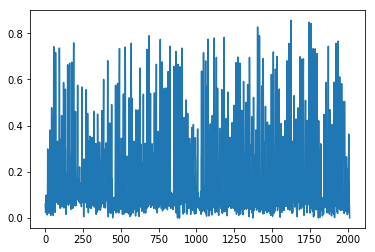

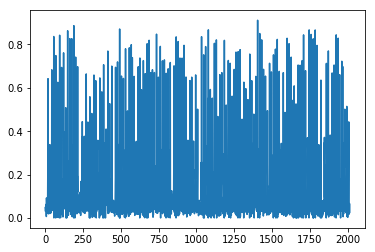

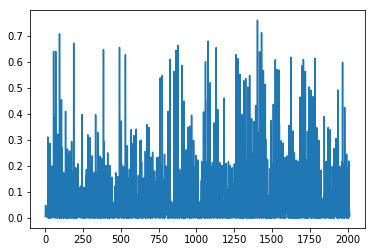

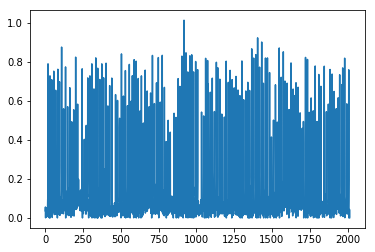

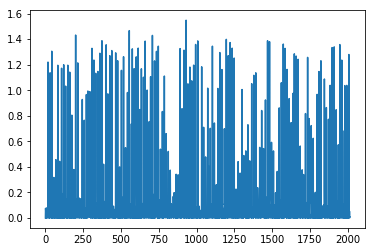

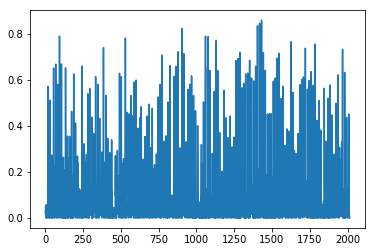

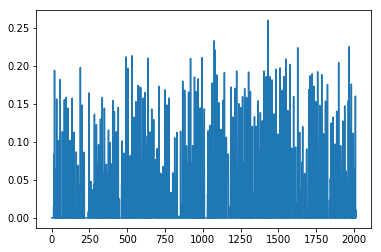

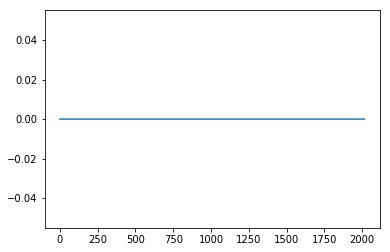

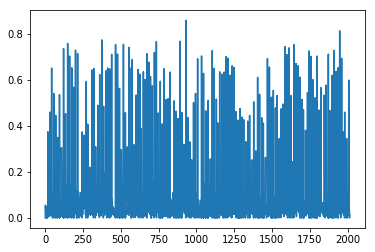

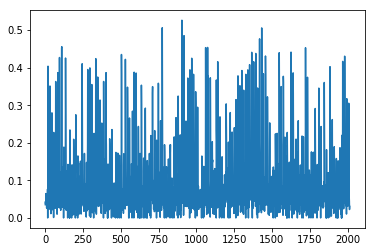

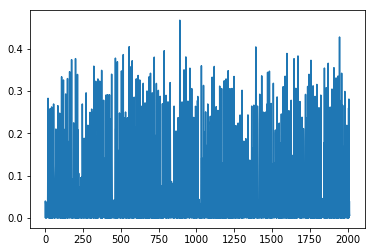

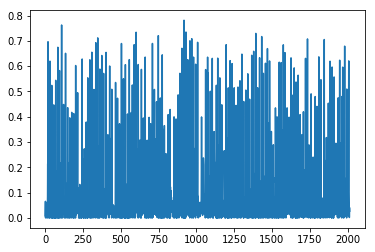

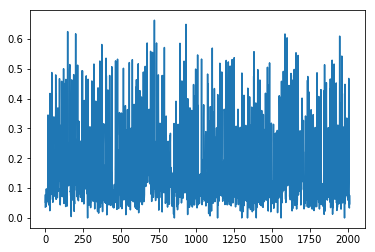

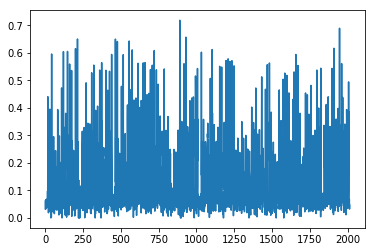

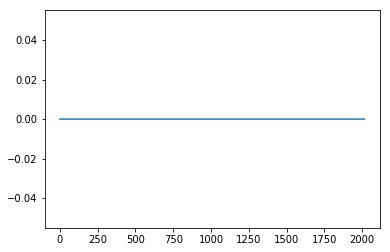

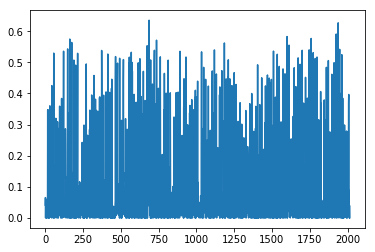

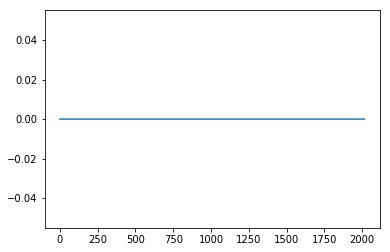

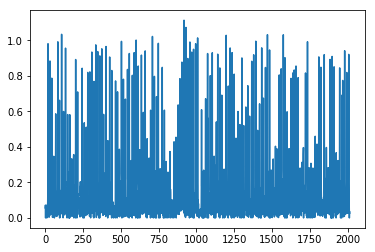

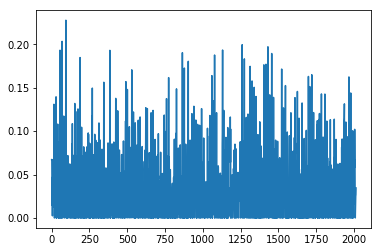

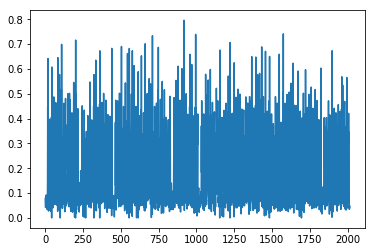

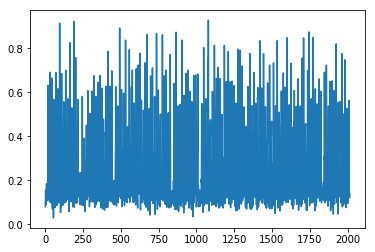

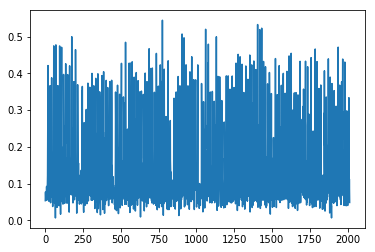

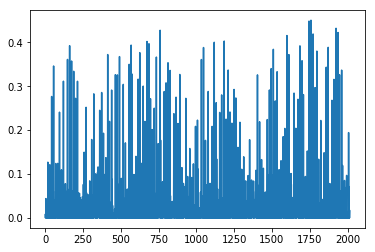

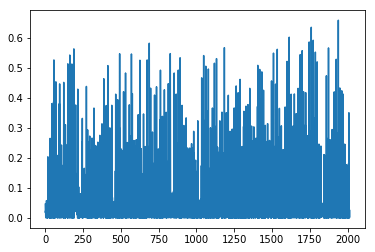

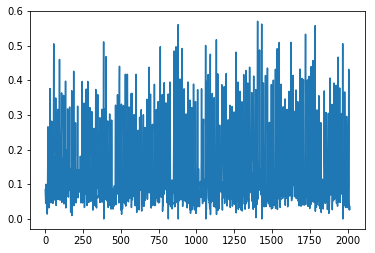

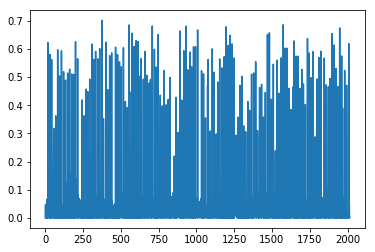

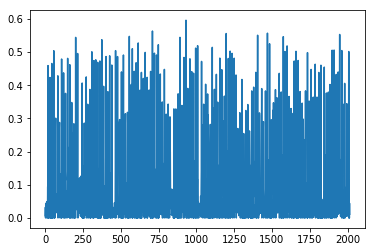

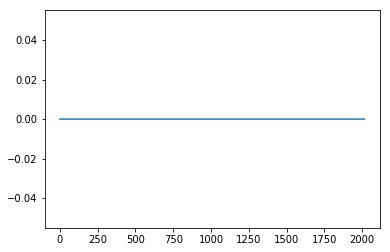

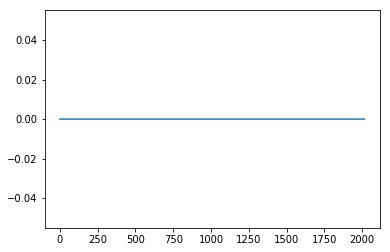

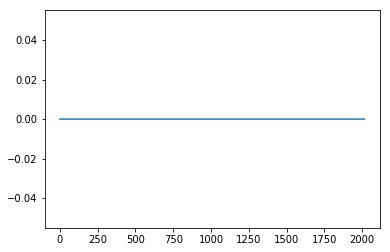

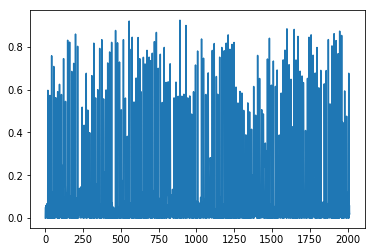

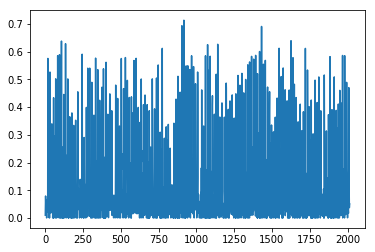

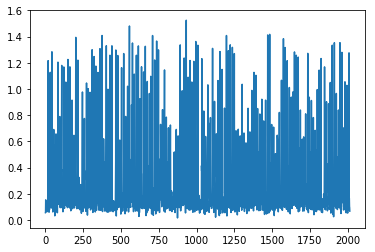

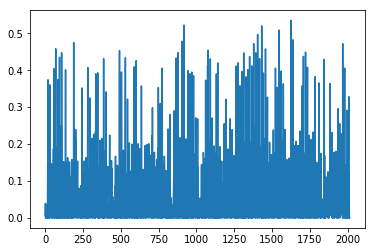

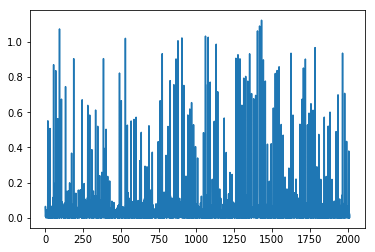

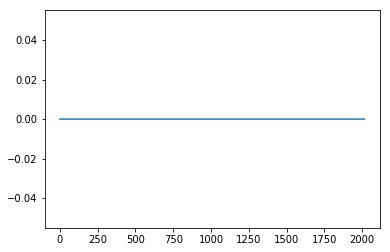

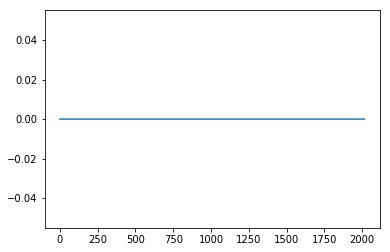

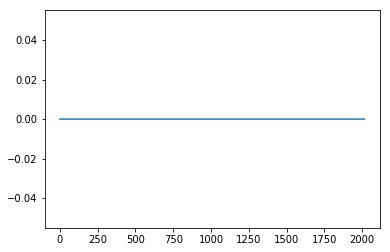

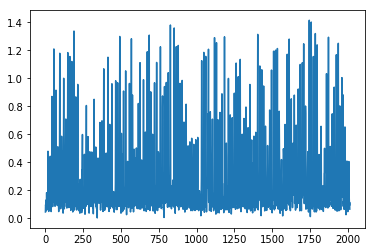

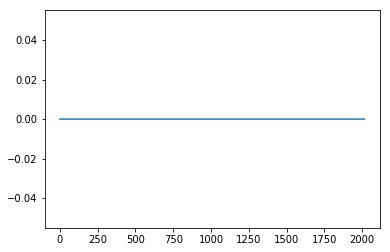

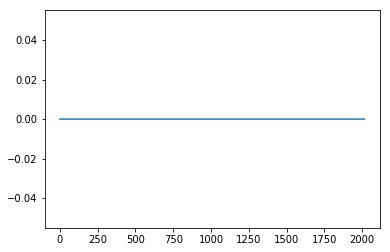

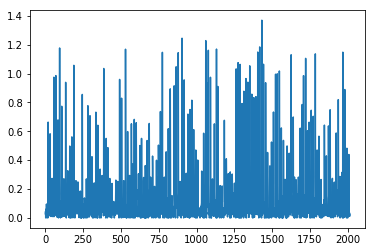

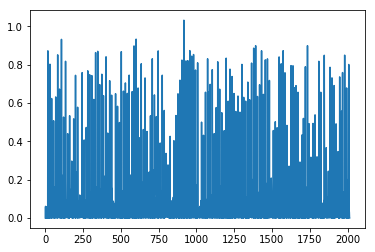

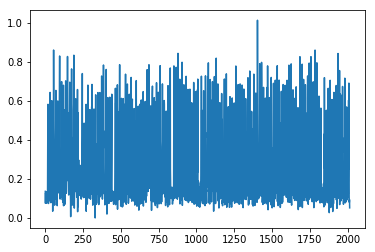

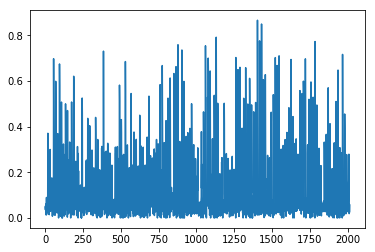

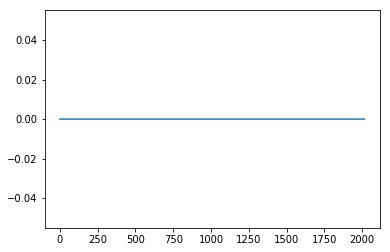

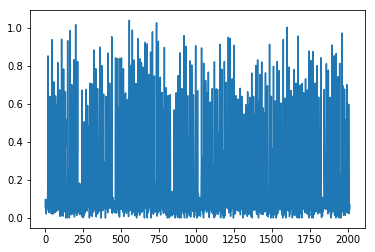

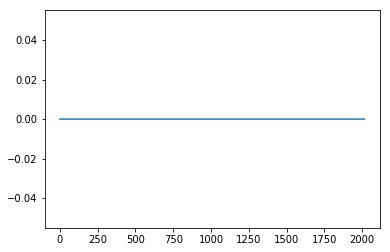

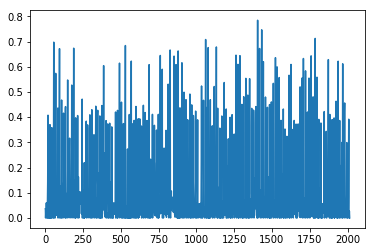

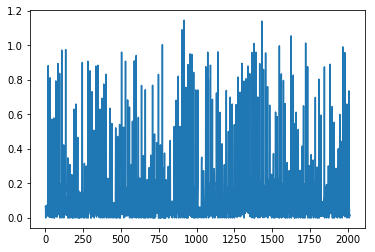

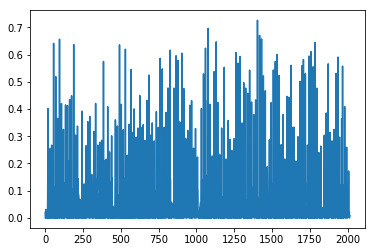

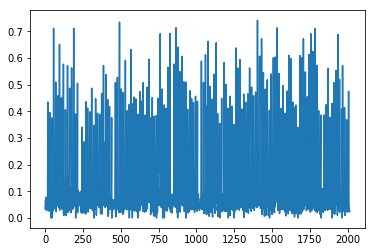

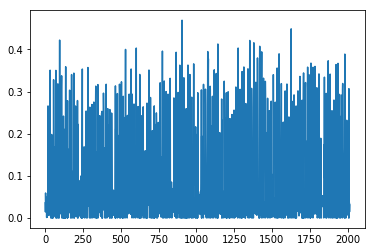

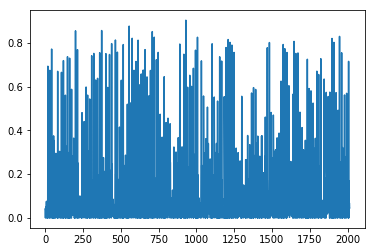

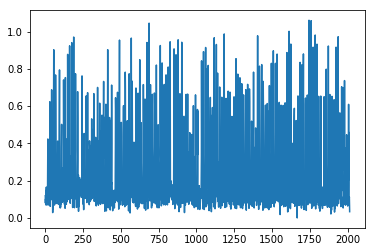

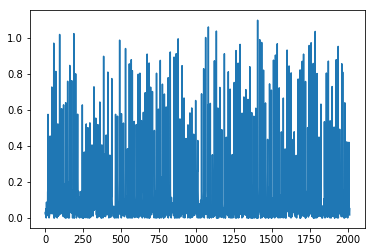

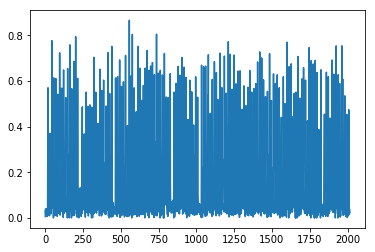

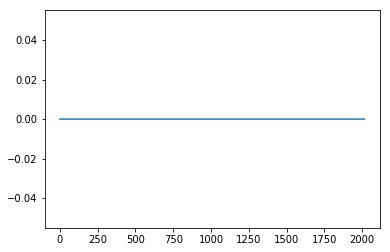

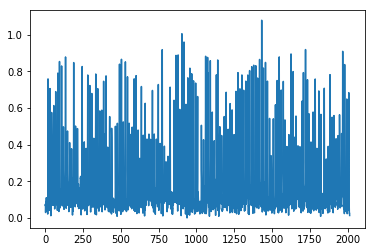

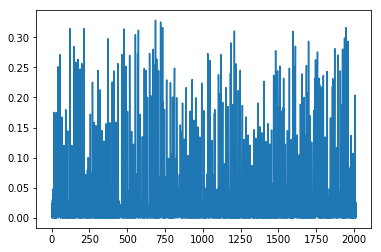

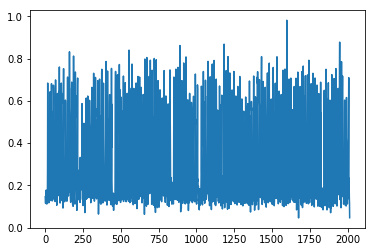

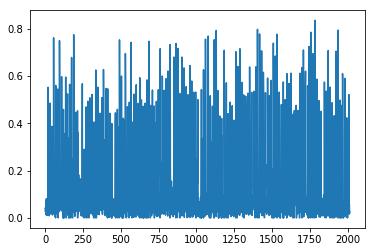

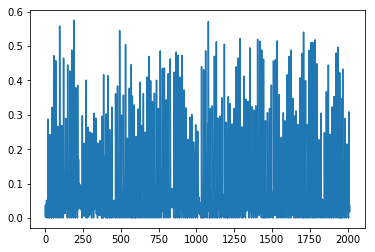

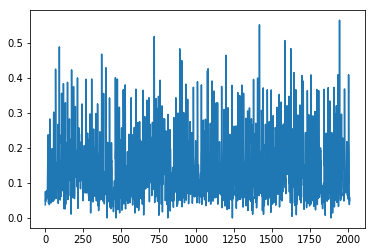

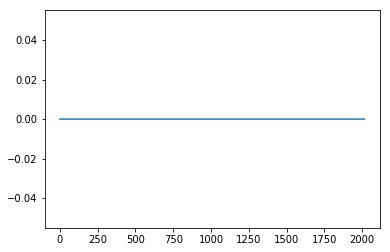

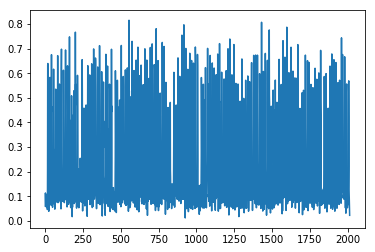

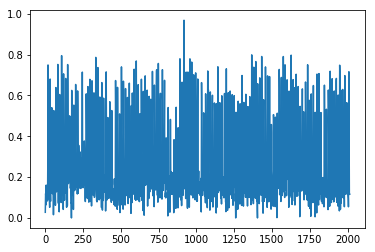

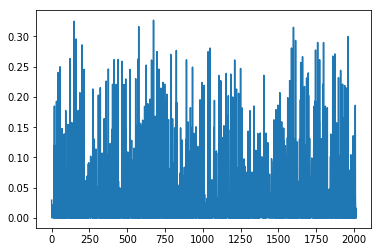

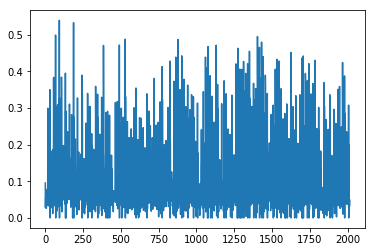

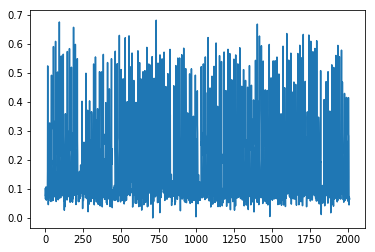

In [76]:
n_s = 0
plt.plot(X_lc_scaled_real[n_s])
plt.show()

for i in range(X_enc_lc_real.shape[-1]):
    plt.plot(X_enc_lc_real[n_s][:,i])
    plt.show()

In [ ]:
##probar cambiar a linear o tanh..

In [25]:
X_train = np.concatenate([X_enc_lc_real[mask_train[mask_conf]], X_enc_lc_aug[mask_train[mask_conf]]], axis=0)
Ystd_train = np.tile(Ystd_train, (2,1))

Ystd_train_err = np.tile(Ystd_train_err, (2,1))

X_test = X_enc_lc_real[mask_test[mask_conf]]

print("X train shape: ",X_train.shape)
print("X test shape: ",X_test.shape)
print("Y train shape: ",Ystd_train.shape)
print("Y test shape: ",Ystd_test.shape)

X train shape:  (3552, 2015, 128)
X test shape:  (505, 2015, 128)
Y train shape:  (3552, 10)
Y test shape:  (505, 10)


### Define Encoder-Metadata

In [26]:
import keras
from keras.models import Sequential
from keras.layers import *
import tensorflow as tf

def mse_masked(y_true, y_pred):
    """ Masked on 0 value.."""
    #mask = K.cast(K.not_equal(y_true, 0), K.floatx())
    e = (y_true - y_pred)*mask
    return K.mean(K.square(e), axis=-1)  #dividir por el error??

def sse(y_true, y_pred):
    e = (y_true - y_pred)
    return K.sum(K.square(e), axis=-1) 

def sae(y_true, y_pred):
    e = (y_true - y_pred)
    return K.sum(K.abs(e), axis=-1) 

#https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
#https://arxiv.org/pdf/1808.08798.pdf
def titled_loss(q):
    def loss(y_true, y_pred):
        mask = K.cast(K.not_equal(y_true, 0), K.floatx())
        e = (y_true - y_pred)*mask
        return K.mean( K.maximum(q*e, (q-1)*e), axis=-1)
    return loss

def train_model(model,X,y,epochs=1,batch_size=32, val_split=0.0):
    return model.fit(X,y, epochs=epochs, batch_size=batch_size, validation_split=val_split)

#autoencoder.compile(loss=[mse_masked],optimizer='adam')
#autoencoder.compile(loss=[titled_loss(0.1)],optimizer='adam') #0.05

In [ ]:
#probar con minimzar absolute error (evitar los valores "extremos"?¡??)
#probar minimizar suma en ves de promedio..

In [27]:
class KMaxPooling(keras.engine.Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension). TensorFlow backend.
    """
    def __init__(self, k=1, **kwargs):
        super().__init__(**kwargs)
        self.input_spec = keras.engine.InputSpec(ndim=3)
        self.k = k

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.k, input_shape[2])

    def call(self, inputs):
        # swap last two dimensions since top_k will be applied along the last dimension
        shifted_input = tf.transpose(inputs, [0, 2, 1]) 
        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(shifted_input, k=self.k, sorted=True, name=None)[0] 
        return tf.transpose(top_k, [0, 2, 1])

import math
def K_l(L,seq_len,k_top,layer=1): #dinamyc k-max
    return max(k_top, math.ceil( seq_len*(L-layer)/L) )

def add_conv_bloq(model, filters, kernel_s, BN=False, drop=0,padding='same',dil_r=1):
    model.add(Conv1D(filters, kernel_s, strides=1, padding=padding, activation='relu',dilation_rate=dil_r))
    if BN:
        model.add(BatchNormalization())
    model.add(Conv1D(filters, kernel_s, strides=1, padding=padding, activation='relu',dilation_rate=dil_r))
    if BN:
        model.add(BatchNormalization())
    if drop != 0:
        model.add(Dropout(drop))

#build model functions..
def build_simple_model(inp_shape,out_shape, units, L =1, drop=0):
    model = Sequential()
    model.add(GlobalAveragePooling1D(input_shape=inp_shape))
    for l in range(L):
        model.add(Dense(units, activation='relu'))
        units = int(units/2)
        if drop > 0.0:
            model.add(Dropout(drop))
    model.add(Dense(out_shape, activation='linear'))
    return model

def build_rnn_model(inp_shape, out_shape, units, layers=1, bid=False, gru=True, drop=0):
    #que achique las unidades?
    model = Sequential()
    model.add(InputLayer(input_shape=inp_shape))
    for i in range(layers):
        if gru:
            layer_rec = GRU(units, return_sequences=(i < layers - 1))
        else:
            layer_rec = LSTM(units, return_sequences=(i < layers - 1))            
        if bid:
            layer_rec = Bidirectional(layer_rec)
        
        model.add(layer_rec)
        if drop > 0.0:
            model.add(Dropout(drop))
    model.add(Dense(out_shape, activation='linear'))
    return model

def build_cnn_model(inp_shape, out_shape, units, L=1, kernel_s =10,
                        pool=5,BN=False,conv_pool=False,drop=0,padding='same',dil_r=1 ): #parametros estructurales
    model = Sequential()
    model.add(InputLayer(input_shape=inp_shape))
    for _ in range(L):
        add_conv_bloq(model, units, kernel_s, BN=BN,drop=drop,padding=padding,dil_r=dil_r)
        if pool!= 0 and dil_r ==1:
            if conv_pool:
                model.add(Conv1D(filters, kernel_s, strides=pool, padding='valid'))
                if BN:
                    model.add(BatchNormalization())
            else:
                #model.add(MaxPool1D(pool_size=pool, strides=pool, padding='valid'))
                model.add(AveragePooling1D(pool_size=pool, strides=pool, padding='valid'))

        if dil_r != 1:
            dil_r = int(dil_r*2)
        else:
            units = int(units*2)
            
    model.add(GlobalAveragePooling1D())  #u otra cosa
       
    model.add(Dense(out_shape, activation='linear'))
    return model

def build_kpool_model(inp_shape, out_shape, units, L=1,kernel_s =10, K_top=500,
                        BN = False, drop=0, padding='same'): #parametros estructurales
    model = Sequential()
    model.add(InputLayer(input_shape=inp_shape))
    for l in range(L):
        add_conv_bloq(model, units, kernel_s, BN=BN,drop=drop,padding=padding)

        model.add(KMaxPooling(k = K_l(L, inp_shape[0], K_top, layer=l+1)))
        units = int(units*2)
    
    model.add(GlobalAveragePooling1D())  #u otra cosa
    
    #d1 = Dense(512,activation='relu')(f1)
    model.add(Dense(out_shape, activation='linear'))
    return model

### RNN model

In [41]:
model_gru = build_rnn_model(X_train.shape[1:], Y_train.shape[1], 128, layers=2, bid=False, gru=True, drop=0)
model_gru.compile(loss='mse', optimizer='adam')
model_gru.summary()
hist = train_model(model_gru, X_train, Ystd_train, epochs=20, batch_size=64, val_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2015, 128)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 2015, 128)         98688     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
Total params: 198,666
Trainable params: 198,666
Non-trainable params: 0
_________________________________________________________________
Train on 2841 samples, validate on 711 samples
Epoch 1/20
2841/2841 [==============================] - 257s 90ms/step - loss: 1.0097 - val_loss: 0.9305
Epoch 2/20
2841/2841 [==============================] - 258s 91ms/step - loss: 1.0039 - val_loss: 0.9321
Epoch 3/20


In [42]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

### Simple

In [36]:
model_simple = build_simple_model(X_train.shape[1:], Ystd_train.shape[1], 64)

#expand dim
model_simple.add(Lambda(lambda x: K.expand_dims(x, axis=-1)))
model_simple.compile(loss='mse', optimizer='adam', sample_weight_mode="temporal")
model_simple.summary()

s_weight = 1. / Ystd_train_err
#sample_weight[np.isnan(sample_weight)] = 0.0
model_simple.fit(X_train, np.expand_dims(Ystd_train,axis=-1), epochs=100, batch_size=64, validation_split=0.2,
                 sample_weight=s_weight)
model_simple.pop()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
_________________________________________________________________
lambda_2 (Lambda)            (None, 10, 1)             0         
Total params: 8,906
Trainable params: 8,906
Non-trainable params: 0
_________________________________________________________________
Train on 2841 samples, validate on 711 samples
Epoch 1/100
2841/2841 [==============================] - 4s 1ms/step - loss: 0.7661 - val_loss: 0.7259
Epoch 2/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.7597 - val_loss: 0.7216
Epoch 3/100
2841/28

2841/2841 [==============================] - 3s 1ms/step - loss: 0.7026 - val_loss: 0.6678
Epoch 72/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.7024 - val_loss: 0.6659
Epoch 73/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.7022 - val_loss: 0.6685
Epoch 74/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.7023 - val_loss: 0.6697
Epoch 75/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.7024 - val_loss: 0.6674
Epoch 76/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.7025 - val_loss: 0.6673
Epoch 77/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.7014 - val_loss: 0.6662
Epoch 78/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.7013 - val_loss: 0.6682
Epoch 79/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.7020 - val_loss: 0.6664
Epoch 80/100
2841/2841 [==============================] - 3s 1ms/step - loss:

In [28]:
model_simple = build_simple_model(X_train.shape[1:], Ystd_train.shape[1], 64)
model_simple.compile(loss='mse', optimizer='adam')
model_simple.summary()
hist = train_model(model_simple, X_train, Ystd_train, epochs=100, batch_size=64, val_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 8,906
Trainable params: 8,906
Non-trainable params: 0
_________________________________________________________________
Train on 2841 samples, validate on 711 samples
Epoch 1/100
2841/2841 [==============================] - 3s 1ms/step - loss: 1.0156 - val_loss: 0.9351
Epoch 2/100
2841/2841 [==============================] - 3s 1ms/step - loss: 1.0104 - val_loss: 0.9344
Epoch 3/100
2841/2841 [==============================] - 4s 1ms/step - loss: 1.0075 - val_loss: 0.9320
Epoch 4/100
2841/2841 [=========================

2841/2841 [==============================] - 3s 1ms/step - loss: 0.9478 - val_loss: 0.8710
Epoch 73/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.9480 - val_loss: 0.8708
Epoch 74/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.9483 - val_loss: 0.8733
Epoch 75/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.9467 - val_loss: 0.8698
Epoch 76/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.9471 - val_loss: 0.8706
Epoch 77/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.9452 - val_loss: 0.8723
Epoch 78/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.9448 - val_loss: 0.8675
Epoch 79/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.9452 - val_loss: 0.8798
Epoch 80/100
2841/2841 [==============================] - 3s 1ms/step - loss: 0.9452 - val_loss: 0.8661
Epoch 81/100
2841/2841 [==============================] - 3s 1ms/step - loss:

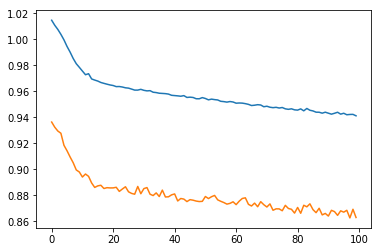

In [44]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

### CNN

In [39]:
#ver si baja overfit.. mas pool?
model_cnn = build_cnn_model(X_train.shape[1:], Y_train.shape[1], 32, L=3, 
                        kernel_s =5, pool=3, BN=False, drop=0.25,padding='valid',dil_r=1 )
model_cnn.compile(loss='mse', optimizer='adam')
model_cnn.summary()

hist = train_model(model_cnn, X_train, Ystd_train, epochs=100, batch_size=64, val_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2015, 128)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 2011, 32)          20512     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 2007, 32)          5152      
_________________________________________________________________
dropout_7 (Dropout)          (None, 2007, 32)          0         
_________________________________________________________________
average_pooling1d_7 (Average (None, 669, 32)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 665, 64)           10304     
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 661, 64)           20544     
__________

2841/2841 [==============================] - 18s 6ms/step - loss: 0.8385 - val_loss: 0.8261
Epoch 57/100
2841/2841 [==============================] - 18s 6ms/step - loss: 0.8421 - val_loss: 0.7881
Epoch 58/100
2841/2841 [==============================] - 18s 6ms/step - loss: 0.8520 - val_loss: 0.7798
Epoch 59/100
2841/2841 [==============================] - 18s 6ms/step - loss: 0.8361 - val_loss: 0.7992
Epoch 60/100
2841/2841 [==============================] - 18s 6ms/step - loss: 0.8378 - val_loss: 0.7918
Epoch 61/100
2841/2841 [==============================] - 18s 6ms/step - loss: 0.8413 - val_loss: 0.8071
Epoch 62/100
2841/2841 [==============================] - 18s 6ms/step - loss: 0.8265 - val_loss: 0.7973
Epoch 63/100
2841/2841 [==============================] - 18s 6ms/step - loss: 0.8224 - val_loss: 0.7969
Epoch 64/100
2841/2841 [==============================] - 20s 7ms/step - loss: 0.8406 - val_loss: 0.7731
Epoch 65/100
2841/2841 [==============================] - 20s 7ms/st

In [40]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

In [47]:
model_cnn2 = build_cnn_model(X_train.shape[1:], Y_train.shape[1], 32, L=3, 
                        kernel_s =5, pool=3, BN=True, drop=0.5,padding='valid',dil_r=1 )
model_cnn2.compile(loss='mse', optimizer='adam')
model_cnn2.summary()

hist = train_model(model_cnn2, X_train, Ystd_train, epochs=100, batch_size=64, val_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 2015, 128)         0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 2011, 32)          20512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2011, 32)          128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 2007, 32)          5152      
_________________________________________________________________
batch_normalization_2 (Batch (None, 2007, 32)          128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 2007, 32)          0         
_________________________________________________________________
average_pooling1d_10 (Averag (None, 669, 32)           0         
__________

Epoch 49/100
2841/2841 [==============================] - 25s 9ms/step - loss: 0.3634 - val_loss: 1.2197
Epoch 50/100
2841/2841 [==============================] - 25s 9ms/step - loss: 0.3544 - val_loss: 1.3718
Epoch 51/100
2841/2841 [==============================] - 25s 9ms/step - loss: 0.3500 - val_loss: 1.1483
Epoch 52/100
2841/2841 [==============================] - 25s 9ms/step - loss: 0.3508 - val_loss: 0.9122
Epoch 53/100
2841/2841 [==============================] - 25s 9ms/step - loss: 0.3393 - val_loss: 1.0767
Epoch 54/100
2841/2841 [==============================] - 26s 9ms/step - loss: 0.3273 - val_loss: 1.3411
Epoch 55/100
2841/2841 [==============================] - 28s 10ms/step - loss: 0.3245 - val_loss: 1.0751
Epoch 56/100
2841/2841 [==============================] - 26s 9ms/step - loss: 0.3220 - val_loss: 1.4072
Epoch 57/100
2841/2841 [==============================] - 28s 10ms/step - loss: 0.3281 - val_loss: 2.4290
Epoch 58/100
2841/2841 [=============================

In [53]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

In [ ]:
#mas pool? otra capa?

In [49]:
model_cnn3 = build_cnn_model(X_train.shape[1:], Y_train.shape[1], 32, L=3, 
                        kernel_s =11, pool=5, BN=False, drop=0.25,padding='valid',dil_r=1 )
model_cnn3.compile(loss='mse', optimizer='adam')
model_cnn3.summary()

hist = train_model(model_cnn3, X_train, Ystd_train, epochs=100, batch_size=64, val_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2015, 128)         0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 2005, 32)          45088     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 1995, 32)          11296     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1995, 32)          0         
_________________________________________________________________
average_pooling1d_13 (Averag (None, 399, 32)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 389, 64)           22592     
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 379, 64)           45120     
__________

2841/2841 [==============================] - 24s 8ms/step - loss: 0.7838 - val_loss: 0.8427
Epoch 57/100
2841/2841 [==============================] - 25s 9ms/step - loss: 0.7601 - val_loss: 0.8012
Epoch 58/100
2841/2841 [==============================] - 24s 8ms/step - loss: 0.7521 - val_loss: 0.8510
Epoch 59/100
2841/2841 [==============================] - 25s 9ms/step - loss: 0.7639 - val_loss: 0.8132
Epoch 60/100
2841/2841 [==============================] - 24s 8ms/step - loss: 0.7371 - val_loss: 0.8346
Epoch 61/100
2841/2841 [==============================] - 24s 8ms/step - loss: 0.7413 - val_loss: 0.9618
Epoch 62/100
2841/2841 [==============================] - 23s 8ms/step - loss: 0.7231 - val_loss: 0.8533
Epoch 63/100
2841/2841 [==============================] - 23s 8ms/step - loss: 0.7139 - val_loss: 0.8608
Epoch 64/100
2841/2841 [==============================] - 23s 8ms/step - loss: 0.7049 - val_loss: 0.8184
Epoch 65/100
2841/2841 [==============================] - 23s 8ms/st

In [54]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

In [51]:
model_cnn4 = build_cnn_model(X_train.shape[1:], Y_train.shape[1], 32, L=4, 
                        kernel_s =5, pool=3, BN=False, drop=0.25,padding='valid',dil_r=1 )
model_cnn4.compile(loss='mse', optimizer='adam')
model_cnn4.summary()

hist = train_model(model_cnn4, X_train, Ystd_train, epochs=100, batch_size=64, val_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 2015, 128)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 2011, 32)          20512     
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 2007, 32)          5152      
_________________________________________________________________
dropout_16 (Dropout)         (None, 2007, 32)          0         
_________________________________________________________________
average_pooling1d_16 (Averag (None, 669, 32)           0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 665, 64)           10304     
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 661, 64)           20544     
__________

2841/2841 [==============================] - 21s 7ms/step - loss: 0.8826 - val_loss: 0.8174
Epoch 52/100
2841/2841 [==============================] - 21s 7ms/step - loss: 0.8547 - val_loss: 0.8211
Epoch 53/100
2841/2841 [==============================] - 21s 7ms/step - loss: 0.8546 - val_loss: 0.7998
Epoch 54/100
2841/2841 [==============================] - 20s 7ms/step - loss: 0.8627 - val_loss: 0.7924
Epoch 55/100
2841/2841 [==============================] - 20s 7ms/step - loss: 0.8439 - val_loss: 0.8080
Epoch 56/100
2841/2841 [==============================] - 21s 7ms/step - loss: 0.8361 - val_loss: 0.7930
Epoch 57/100
2841/2841 [==============================] - 21s 8ms/step - loss: 0.8447 - val_loss: 0.7952
Epoch 58/100
2841/2841 [==============================] - 22s 8ms/step - loss: 0.8362 - val_loss: 0.7893
Epoch 59/100
2841/2841 [==============================] - 21s 7ms/step - loss: 0.8423 - val_loss: 0.7976
Epoch 60/100
2841/2841 [==============================] - 21s 7ms/st

In [55]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

### CNN K-max pool

In [45]:
model_kpool = build_kpool_model(X_train.shape[1:], Y_train.shape[1], 32, L=3,
                        kernel_s =5, K_top=100, BN = False, drop=0, padding='valid') #menos k??
model_kpool.compile(loss='mse', optimizer='adam')
model_kpool.summary()

hist = train_model(model_kpool, X_train, Ystd_train, epochs=100, batch_size=64, val_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2015, 128)         0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 2011, 32)          20512     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 2007, 32)          5152      
_________________________________________________________________
k_max_pooling_1 (KMaxPooling (None, 1344, 32)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1340, 64)          10304     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1336, 64)          20544     
_________________________________________________________________
k_max_pooling_2 (KMaxPooling (None, 672, 64)           0         
__________

Epoch 60/100
2841/2841 [==============================] - 36s 13ms/step - loss: 0.8066 - val_loss: 0.7895
Epoch 61/100
2841/2841 [==============================] - 35s 12ms/step - loss: 0.8131 - val_loss: 0.7763
Epoch 62/100
2841/2841 [==============================] - 35s 12ms/step - loss: 0.8248 - val_loss: 0.7711
Epoch 63/100
2841/2841 [==============================] - 35s 12ms/step - loss: 0.8206 - val_loss: 0.7826
Epoch 64/100
2841/2841 [==============================] - 35s 12ms/step - loss: 0.7999 - val_loss: 0.7652
Epoch 65/100
2841/2841 [==============================] - 35s 12ms/step - loss: 0.7985 - val_loss: 0.7762
Epoch 66/100
2841/2841 [==============================] - 35s 12ms/step - loss: 0.7808 - val_loss: 0.7602
Epoch 67/100
2841/2841 [==============================] - 35s 12ms/step - loss: 0.7911 - val_loss: 0.7526
Epoch 68/100
2841/2841 [==============================] - 36s 13ms/step - loss: 0.7827 - val_loss: 0.7681
Epoch 69/100
2841/2841 [======================

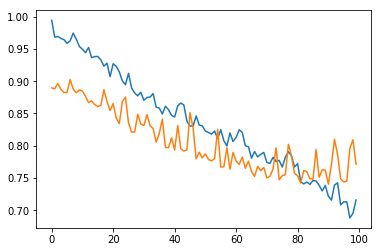

In [46]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

### CNN casual+dilation 
> WaveNet

In [ ]:
model_cnn_caus = build_cnn_model(X_train.shape[1:], Y_train.shape[1], 32, L=3, 
                        kernel_s =5, BN=False, drop=0.0, padding='causal',dil_r=2 )
model_cnn_caus.compile(loss='mse', optimizer='adam')
model_cnn_caus.summary()

hist = train_model(model_cnn_caus, X_train, Ystd_train, epochs=100, batch_size=64, val_split=0.2)

In [ ]:
#sin globalmaxpool.. tomar el ultimo..
out = layers.Lambda(lambda x: x[:, -1, :], output_shape=(out._keras_shape[-1],))(
            out)
#6 capas para que vea todo..

### train model (2da fase)

In [ ]:
... opciones
#1 probar sin pre-process -- malo pero no tanto...
#2 probar con pre-process standar -- el mejor
#3 probar con pre-process robust --- bien

#4 probar añadiendo error -- mejora pero la nada misma...

#5 probar variar arquitecturas..

#6 probar añadir otras curvas (sin confirmados..)

In [37]:
model = model_simple #model_kpool
Y_train_hat = model.predict(X_train)
Y_test_hat = model.predict(X_test)

## Evaluate

In [74]:
from sklearn.decomposition import PCA
model = PCA(2)
plot_enc = model.fit_transform(Y_train_hat)

plt.figure(figsize=(10,5))
plt.scatter(plot_enc[:,0],plot_enc[:,1])
plt.show()

model = PCA(2)
plot_enc = model.fit_transform(Ystd_train)

plt.figure(figsize=(10,5))
plt.scatter(plot_enc[:,0],plot_enc[:,1])
plt.show()

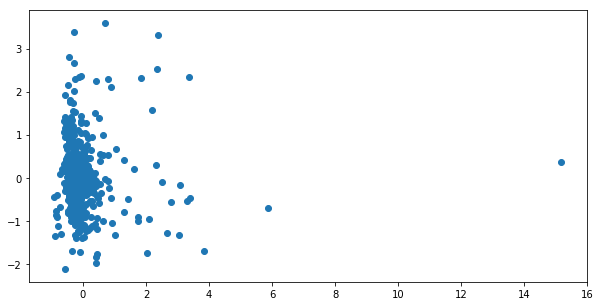

In [75]:
from sklearn.decomposition import PCA
model = PCA(2)
plot_enc = model.fit_transform(Y_test_hat)

plt.figure(figsize=(10,5))
plt.scatter(plot_enc[:,0],plot_enc[:,1])
plt.show()

model = PCA(2)
plot_enc = model.fit_transform(Ystd_test)

plt.figure(figsize=(10,5))
plt.scatter(plot_enc[:,0],plot_enc[:,1])
plt.show()

In [45]:
from IPython.display import display, HTML
from sklearn.metrics import mean_absolute_error,mean_squared_error, median_absolute_error
def plot_n_meta(real, pred, n= 10, plot_real = True):
    if plot_real:
        pred = scaler_meta.inverse_transform(pred)
    for _ in range(n):
        n_sampled = np.random.randint(0,real.shape[0])
        aux = pd.DataFrame()
        aux["Real"] = real[n_sampled]
        aux["Predicted"] = pred[n_sampled]
        aux.index=metadata_used
        display(aux.transpose())
        print("----------------------------------------------------------------")

def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def evaluate_meta(real, pred, scaler_meta, plot=True):
    res_metadata = {}
    inv_real = scaler_meta.inverse_transform(real)
    inv_pred = scaler_meta.inverse_transform(pred)
    res_metadata["MSE"] = [mean_squared_error(inv_real, inv_pred), mean_squared_error(real, pred)]
    res_metadata["MAE"] = [mean_absolute_error(inv_real, inv_pred), mean_absolute_error(real, pred)]
    res_metadata["MeAE"] = [calculate_median_abs_err(inv_real, inv_pred), calculate_median_abs_err(real, pred)]
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = ["Real","Scaled"]
        print(df)
    return res_metadata

def evaluate_meta_raw(real, pred, plot=True):
    res_metadata = {}
    inv_real = scaler_meta.inverse_transform(real)
    inv_pred = scaler_meta.inverse_transform(pred)
    
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    for d in range(inv_real.shape[1]):
        mse_raw.append(mean_squared_error(inv_real[:,d], inv_pred[:,d]))
        mae_raw.append(mean_absolute_error(inv_real[:,d], inv_pred[:,d]))
        mEae_raw.append(median_absolute_error(inv_real[:,d], inv_pred[:,d]))
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        display(df.transpose())
    return res_metadata

In [76]:
###  plot some examples..
print("Train")
plot_n_meta(Y_train, Y_train_hat)
print("Test")
plot_n_meta(Y_test, Y_test_hat)

Train


Period  Duration  Time of Transit Epoch  Inclination  \
Real        6.178174  3.260100             168.862600    85.280000   
Predicted  18.873339  4.192289             174.186798    86.812027   

           Semi-major Axis       r/R          Teq  Transit Number  \
Real              0.064000  0.010000  1082.000000       155.00000   
Predicted         0.103721  0.021324   958.362854       175.86554   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.345000               0.292000  
Predicted               0.423553               0.247001

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real       4.417693  2.323000             133.961390    78.170000   
Predicted  4.007141  3.101165             143.657074    87.116989   

           Semi-major Axis       r/R          Teq  Transit Number  \
Real               0.04700  0.022000   790.000000      302.000000   
Predicted          0.06841  0.017227  1032.741333      320.687836   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.611000               0.120000  
Predicted               0.414174               0.255161

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real       22.184318  3.039700             174.597325    89.970000   
Predicted  19.229513  4.011157             163.778870    88.930824   

           Semi-major Axis       r/R         Teq  Transit Number  \
Real              0.142000  0.036000  546.000000       58.000000   
Predicted         0.142112  0.033208  591.873352       80.844666   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.497000               0.204000  
Predicted               0.471581               0.216492

----------------------------------------------------------------


Period   Duration  Time of Transit Epoch  Inclination  \
Real       150.241258  10.849000             138.290130     89.81000   
Predicted  127.331299   9.857064             198.334991     89.80703   

           Semi-major Axis       r/R         Teq  Transit Number  \
Real              0.537000  0.045000  327.000000       10.000000   
Predicted         0.468302  0.032534  418.335724      -26.330652   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.453000               0.233000  
Predicted               0.399354               0.260935

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real        3.813714   1.97300             132.574650    88.780000   
Predicted  36.865051   3.30475             157.940308    88.716393   

           Semi-major Axis       r/R          Teq  Transit Number  \
Real              0.046000  0.015000  1029.000000      348.000000   
Predicted         0.166627  0.022331   605.287231      245.649185   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.442000                0.24000  
Predicted               0.500088                0.21021

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real       11.128274  2.611800             139.544170    88.830000   
Predicted  12.947070  2.519562             170.097168    89.283463   

           Semi-major Axis       r/R         Teq  Transit Number  \
Real              0.078000  0.074000  408.000000       58.000000   
Predicted         0.081372  0.046701  640.747314      181.025375   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.531000               0.211000  
Predicted               0.484381               0.221128

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real       19.023136  3.431000             139.659880    88.730000   
Predicted  11.113993  3.539658             145.988968    87.523499   

           Semi-major Axis       r/R         Teq  Transit Number  \
Real               0.13700  0.020000  647.000000       70.000000   
Predicted          0.09601  0.017589  944.238037      253.715988   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.460000               0.229000  
Predicted               0.417433               0.252666

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real       15.378901  4.662000             143.406290    89.140000   
Predicted  26.594948  3.384188             150.084106    89.903931   

           Semi-major Axis       r/R         Teq  Transit Number  \
Real              0.131000  0.013000  1039.00000       90.000000   
Predicted         0.154411  0.015253   613.86145      141.142517   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.413000               0.260000  
Predicted               0.506709               0.204306

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real        6.921015  4.359100             135.643430    84.600000   
Predicted  21.228785  3.169001             157.725266    88.307251   

           Semi-major Axis      r/R         Teq  Transit Number  \
Real              0.059000  0.02300  619.000000      193.000000   
Predicted         0.118982  0.02475  713.205505      178.171356   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.641000               0.097000  
Predicted               0.476677               0.220072

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real       4.662719  2.757000             134.082960    87.660000   
Predicted  1.836841  2.457202             161.108597    87.947945   

           Semi-major Axis       r/R          Teq  Transit Number  \
Real              0.056000  0.038000  1039.000000      233.000000   
Predicted         0.042079  0.036915   888.507019      257.541443   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                     0.41900                0.25600  
Predicted                0.48217                0.21161

----------------------------------------------------------------
Test


Period  Duration  Time of Transit Epoch  Inclination  \
Real        2.886762  0.987900             131.665920     84.91000   
Predicted  28.624956  3.455107             164.892975     89.12484   

           Semi-major Axis       r/R         Teq  Transit Number  \
Real              0.030000  0.029000  557.000000      269.000000   
Predicted         0.144113  0.026891  575.166931      147.966156   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.387000               0.341000  
Predicted               0.539175               0.181613

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real       14.305176  4.535000             135.063010     85.25000   
Predicted  12.017269  3.217666             173.218323     88.61898   

           Semi-major Axis       r/R         Teq  Transit Number  \
Real              0.113000  0.033000  693.000000       74.000000   
Predicted         0.108393  0.028872  611.367859      126.960098   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.386000               0.271000  
Predicted               0.543071               0.173865

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real        5.600133  2.650800             135.964950    89.840000   
Predicted  25.391373  4.266672             152.536789    88.638535   

           Semi-major Axis       r/R         Teq  Transit Number  \
Real              0.059000  0.016000  952.000000      236.000000   
Predicted         0.155009  0.019817  686.852173      117.452095   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.526000               0.186000  
Predicted               0.437023               0.238144

----------------------------------------------------------------


Period   Duration  Time of Transit Epoch  Inclination  \
Real       175.138920  10.767000             296.037780    89.970000   
Predicted   17.122492   3.545745             149.043182    87.349182   

           Semi-major Axis       r/R        Teq  Transit Number  \
Real              0.610000  0.023000  346.00000        8.000000   
Predicted         0.103377  0.018593  977.61145      310.210846   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.472000               0.225000  
Predicted               0.423586               0.245742

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real       25.193399  4.620000             146.430100    88.780000   
Predicted  19.043550  3.912632             146.979904    87.566277   

           Semi-major Axis       r/R        Teq  Transit Number  \
Real              0.156000  0.021000  513.00000       50.000000   
Predicted         0.114774  0.017914  939.66272      290.140625   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.582000                0.14500  
Predicted               0.417836                0.24989

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real        2.685054  1.047300             132.604430    86.690000   
Predicted  25.539942  3.460608             149.621384    88.298393   

           Semi-major Axis       r/R          Teq  Transit Number  \
Real              0.035000  0.016000  1137.000000        499.0000   
Predicted         0.140958  0.020127   734.530396        240.9534   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.490000               0.207000  
Predicted               0.475223               0.219859

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real        2.888904  1.604300             132.152710    85.230000   
Predicted  32.838005  3.590017             163.696686    88.831589   

           Semi-major Axis       r/R        Teq  Transit Number  \
Real              0.037000  0.020000  976.00000      457.000000   
Predicted         0.162858  0.025214  590.62323      168.301544   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.582000               0.145000  
Predicted               0.497161               0.209274

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real       3.949627  1.548500             134.610960    89.860000   
Predicted -3.883318  2.806272             145.216965    87.011894   

           Semi-major Axis       r/R          Teq  Transit Number  \
Real              0.046000  0.025000   966.000000      341.000000   
Predicted         0.038498  0.017387  1059.080078      339.219025   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.517000               0.191000  
Predicted               0.416053               0.254699

----------------------------------------------------------------


Period   Duration  Time of Transit Epoch  Inclination  \
Real       127.833500  10.914000             293.418450    89.720000   
Predicted   23.540039   5.723594             153.508362    87.427795   

           Semi-major Axis       r/R         Teq  Transit Number  \
Real              0.583000  0.040000  554.000000       10.000000   
Predicted         0.153203  0.014449  962.855408      131.404816   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.299000               0.322000  
Predicted               0.356907               0.288733

----------------------------------------------------------------


Period  Duration  Time of Transit Epoch  Inclination  \
Real        8.295617  1.342100             135.792840    87.950000   
Predicted  31.790047  3.707035             159.720093    88.713997   

           Semi-major Axis       r/R        Teq  Transit Number  \
Real              0.065000  0.032000  469.00000      119.000000   
Predicted         0.161496  0.024257  579.64917      157.670532   

           Limb Darkening Coeff1  Limb Darkening Coeff2  
Real                    0.477000               0.258000  
Predicted               0.521128               0.190595

----------------------------------------------------------------


In [32]:
##evaluate with mse between metadata (and the values before)..
print("**********************Train**********************")
evaluate_meta(Ystd_train, Y_train_hat)
print("**********************Test**********************")
evaluate_meta(Ystd_test, Y_test_hat) #simple

**********************Train**********************
              MAE          MSE
Real    50.074463  23557.86099
Scaled   0.622709      0.92623
**********************Test**********************
              MAE           MSE
Real    47.020024  19920.087455
Scaled   0.616594      0.865586


{'MAE': [47.02002446871029, 0.6165944469554567],
 'MSE': [19920.08745524141, 0.8655859952906901]}

In [64]:
##evaluate with mse between metadata (and the values before)..
print("**********************Train**********************")
evaluate_meta(Ystd_train, Y_train_hat)
print("**********************Test**********************")
evaluate_meta(Ystd_test, Y_test_hat)

**********************Train**********************
              MAE           MSE
Real    39.963039  16821.813309
Scaled   0.504593      0.683698
**********************Test**********************
              MAE           MSE
Real    44.148538  18610.569516
Scaled   0.569110      0.851242


{'MAE': [44.14853779516021, 0.5691097884579979],
 'MSE': [18610.569516110514, 0.851242031713418]}

In [60]:
##evaluate with mse between metadata (and the values before)..
print("**********************Train**********************")
evaluate_meta(Ystd_train, Y_train_hat)
print("**********************Test**********************")
evaluate_meta(Ystd_test, Y_test_hat) #kmaxpool

**********************Train**********************
              MAE           MSE
Real    41.578078  18577.621386
Scaled   0.512222      0.707987
**********************Test**********************
              MAE           MSE
Real    42.164966  18254.896155
Scaled   0.549248      0.834414


{'MAE': [42.164965967733245, 0.5492480562664349],
 'MSE': [18254.896154653, 0.834414480212583]}

In [77]:
#evaluatet by column
print("**********************Train**********************")
evaluate_meta_raw(Ystd_train, Y_train_hat)
print("**********************Test**********************")
evaluate_meta_raw(Ystd_test, Y_test_hat)

**********************Train**********************


Period  Duration  Time of Transit Epoch  Inclination  \
MAE    19.086512  1.368742              23.088106     1.767360   
MSE  1998.059658  4.501084            1481.956912    10.718267   

     Semi-major Axis       r/R            Teq  Transit Number  \
MAE         0.069492  0.007327     233.707946      136.571096   
MSE         0.014218  0.000136  108350.024695    73930.927322   

     Limb Darkening Coeff1  Limb Darkening Coeff2  
MAE               0.068675               0.045522  
MSE               0.007763               0.003808

**********************Test**********************


Period  Duration  Time of Transit Epoch  Inclination  \
MAE    21.250090  1.629325              24.577114     1.919690   
MSE  1765.634413  6.116355            1637.418831    11.994011   

     Semi-major Axis       r/R            Teq  Transit Number  \
MAE         0.078812  0.009177     231.382556      140.688376   
MSE         0.017005  0.000553  102004.374645    77123.394234   

     Limb Darkening Coeff1  Limb Darkening Coeff2  
MAE               0.069252               0.045267  
MSE               0.007812               0.003688

{'MAE': [21.250089971337513,
  1.6293254889349607,
  24.57711394471109,
  1.9196896591941903,
  0.07881165955823542,
  0.00917736119169115,
  231.382556454498,
  140.6883756278765,
  0.0692522294712539,
  0.04526728055902047],
 'MSE': [1765.6344131087267,
  6.116354881654875,
  1637.4188313192938,
  11.994011199995844,
  0.017004619276247107,
  0.0005526856542424689,
  102004.37464450012,
  77123.3942341662,
  0.00781167354692435,
  0.003688376240429244]}

### acc obtain with new encoder rep..

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, accuracy_score, precision_score
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score_we':make_scorer(f1_score,average='weighted'),
    'f1_score_macro':make_scorer(f1_score,average='macro'),
    'f1_score_micro':make_scorer(f1_score,average='micro')
}

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
param_grid = {
    'n_estimators' : [10,20,30,40,50,60,70,80,90,100],
    'min_samples_split': [2,5,10,15,20,25],
    #'max_depth': np.arange(5,25),
    'class_weight' : ['balanced','balanced_subsample',None]
}

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit='f1_score_we',
                       cv=skf, return_train_score=False, n_jobs=-1)
grid_search.fit(X_train_encoder, y_train)

print('Best params for completeness:', grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
bestResults = results[results.params == grid_search.best_params_]
completeness = float(bestResults['mean_test_recall_score'])
print('Completion: {:.4f}'.format(completeness))
preci = float(bestResults['mean_test_precision_score'])
print('Contamination: {:.4f}'.format(1-preci))
f1_w = float(bestResults['mean_test_f1_score_we'])
print('F1-score weighted: {:.4f}'.format(f1_w))
f1_ma = float(bestResults['mean_test_f1_score_macro'])
print('F1-score macro: {:.4f}'.format(f1_ma))
f1_mi = float(bestResults['mean_test_f1_score_micro'])
print('F1-score micro: {:.4f}'.format(f1_mi))

In [ ]:
X_test_encoder = encoder.predict(X_test)

model = RandomForestClassifier(n_jobs=-1, random_state=0, **grid_search.best_params_) 
model.fit(X_train_encoder,y_train) 

ypred_train = model.predict(X_train_encoder)
ypred_test = model.predict(X_test_encoder)

In [ ]:
print("Train")
aux = calculate_metrics(y_train, ypred_train)
print("Test")
aux = calculate_metrics(y_test, ypred_test) #focal loss?